# CoDA multi-run metrics (fixed refs + extinction reset)

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from typing import List

from spatial_environments import GridEnvRightDownNoSelf, GridEnvRightDownNoCue
from util import generate_dataset, generate_dataset_post_augmentation
from coda_metrics import kl_over_time, entropy_over_time, markovization_score, ref_empirical_from_rollouts, greedy_right_down_policy
from coda_trial_by_trial_util import CoDAAgent, CoDAConfig


In [3]:

N_SEEDS   = 30
SEED0     = 0
N_ACQ     = 250
N_EXT     = 300
MAX_STEPS = 20
CUE       = 5

cfg = CoDAConfig(
    theta_split=0.9, theta_merge=0.6,
    n_threshold=8, min_presence_episodes=8, min_effective_exposure=25.0,
    confidence=0.95,
    count_decay=0.995,
    trace_decay=0.99,
    retro_decay=0.99
)

N_ROLL_REF_FIX = 3000


In [4]:
# ================== clone-aware / no-clone GT for metrics ==================

import numpy as np

def _n_actions(env):
    return max(a for acts in env.valid_actions.values() for a in acts) + 1

def _base_successor(env, s, a):
    i, j  = env.state_to_pos[s]
    di, dj = env.base_actions[a]
    ni, nj = i + di, j + dj
    return env.pos_to_state.get((ni, nj), s)

def _build_base_T(env):
    S0 = env.num_unique_states
    A  = _n_actions(env)
    T  = np.zeros((S0, A, S0), dtype=float)
    terminals = set(env.rewarded_terminals) | set(env.unrewarded_terminals)
    for s, acts in env.valid_actions.items():
        if s in terminals: 
            continue  # absorbing
        for a in acts:
            sp = _base_successor(env, s, a)
            T[s, a, sp] = 1.0
    return T

def _descendants_until_terminal(env, start, terminals):
    """All base states reachable from `start` before any terminal."""
    adj = {s: [_base_successor(env, s, a) for a in env.valid_actions.get(s, [])]
           for s in range(env.num_unique_states)}
    seen, Q = set(), [start]
    while Q:
        s = Q.pop(0)
        for sp in adj.get(s, []):
            if sp in terminals: 
                continue
            if sp not in seen:
                seen.add(sp); Q.append(sp)
    return seen

def build_gt_acquisition_with_clones(env, cue_state: int) -> np.ndarray:
    """
    Analytic GT for acquisition:
      - clone *all* descendants of the cue (until terminal)
      - cue→descendant edges go to clones; transitions within branch stay in clones
      - clone→terminal = rewarded; original pre-terminal→paired unrewarded
    """
    S0 = env.num_unique_states
    A  = _n_actions(env)
    T0 = _build_base_T(env)

    terminals = set(env.rewarded_terminals) | set(env.unrewarded_terminals)
    rewT = env.rewarded_terminals
    unrewT = env.unrewarded_terminals

    # originals to clone (pre-term)
    D = _descendants_until_terminal(env, cue_state, terminals)

    # allocate clones
    clone_of = {orig: S0 + k for k, orig in enumerate(sorted(D))}
    S = S0 + len(clone_of)
    T = np.zeros((S, A, S), dtype=float)
    T[:S0, :, :S0] = T0  # start from base transitions

    # (1) cue redirection into clones
    for a in env.valid_actions[cue_state]:
        sp = _base_successor(env, cue_state, a)
        if sp in D:
            T[cue_state, a, sp] = 0.0
            T[cue_state, a, clone_of[sp]] = 1.0

    # (2) clone branch dynamics + original pre-term → unrewarded
    for orig, cl in clone_of.items():
        for a in env.valid_actions[orig]:
            sp = _base_successor(env, orig, a)
            if sp in terminals:
                # clone hits terminal → rewarded
                for t in rewT:  T[cl, a, t] = 1.0
                for t in unrewT: T[cl, a, t] = 0.0
            else:
                T[cl, a, clone_of[sp] if sp in clone_of else sp] = 1.0

        # original pre-terminal → paired UNREWARDED (not rewarded)
        for a in env.valid_actions[orig]:
            sp = _base_successor(env, orig, a)
            if sp in rewT:
                T[orig, a, sp] = 0.0
                idx = rewT.index(sp)
                T[orig, a, unrewT[idx]] = 1.0

    return T  # shape [S0 + |D|, A, S0 + |D|]

def build_gt_extinction_no_clones(env2) -> np.ndarray:
    """
    Analytic GT for extinction:
      - base deterministic transitions
      - any s→rewarded-terminal is redirected to the paired UNREWARDED terminal
      - no clones
    """
    T = _build_base_T(env2)
    for s in range(env2.num_unique_states):
        for a in env2.valid_actions.get(s, []):
            sp = _base_successor(env2, s, a)
            if sp in env2.rewarded_terminals:
                idx = env2.rewarded_terminals.index(sp)
                T[s, a, sp] = 0.0
                T[s, a, env2.unrewarded_terminals[idx]] = 1.0
    return T

def _pad3(arr: np.ndarray, shape: tuple) -> np.ndarray:
    """Zero-pad a [S,A,S] tensor to `shape` without cropping."""
    S, A, S2 = arr.shape
    Sg, Ag, S2g = shape
    if (S, A, S2) == (Sg, Ag, S2g): 
        return arr
    out = np.zeros((Sg, Ag, S2g), dtype=float)
    out[:min(S,Sg), :min(A,Ag), :min(S2,S2g)] = arr[:min(S,Sg), :min(A,Ag), :min(S2,S2g)]
    return out

def _ref_fn_fixed(T_fixed: np.ndarray):
    """Return a callable for kl_over_time that always returns a padded fixed GT."""
    def _fn(T_learned):
        shape = tuple(max(x,y) for x,y in zip(T_learned.shape, T_fixed.shape))
        return _pad3(T_fixed, shape)
    return _fn

In [5]:
def run_one_seed(seed:int):
    np.random.seed(seed)

    # -------- Acquisition env + GT (clone-aware) --------
    env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])

    # Build the analytic GT **with clones** once per seed
    T_ref_acq_fixed = build_gt_acquisition_with_clones(env, cue_state=CUE)
    ref_fn_acq = _ref_fn_fixed(T_ref_acq_fixed)

    agent = CoDAAgent(env, cfg)

    # --- acquisition rollout ---
    T_series_acq = []
    with_clones = False
    for ep in range(1, N_ACQ+1):
        if with_clones:
            (states, actions) = generate_dataset_post_augmentation(env, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
        else:
            (states, actions) = generate_dataset(env, n_episodes=1, max_steps=MAX_STEPS)[0]
        agent.update_with_episode(states, actions)
        if agent.maybe_split():
            with_clones = True
        T_series_acq.append(agent.get_T().copy())

    # -------- Extinction env + GT (no clones; all → unrewarded) --------
    env2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
    env2.clone_dict = dict(getattr(env, "clone_dict", {}))
    env2.reverse_clone_dict = dict(getattr(env, "reverse_clone_dict", {}))
    agent.env = env2

    T_ref_ext_fixed = build_gt_extinction_no_clones(env2)  # build once per seed
    ref_fn_ext = _ref_fn_fixed(T_ref_ext_fixed)

    # --- extinction rollout ---
    T_series_ext = []
    for ep in range(N_ACQ+1, N_ACQ+N_EXT+1):
        (states, actions) = generate_dataset_post_augmentation(env2, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
        agent.update_with_episode(states, actions)
        agent.maybe_merge()
        T_series_ext.append(agent.get_T().copy())

    # ---- metrics against the fixed GTs ----
    KL_acq = kl_over_time(T_series_acq, ref_fn_acq, use_js=False)
    JS_acq = kl_over_time(T_series_acq, ref_fn_acq, use_js=True)
    H_acq  = entropy_over_time(T_series_acq)
    MS_acq = np.array([markovization_score(T) for T in T_series_acq])

    KL_ext = kl_over_time(T_series_ext, ref_fn_ext, use_js=False)
    JS_ext = kl_over_time(T_series_ext, ref_fn_ext, use_js=True)
    H_ext  = entropy_over_time(T_series_ext)
    MS_ext = np.array([markovization_score(T) for T in T_series_ext])

    return dict(KL_acq=KL_acq, JS_acq=JS_acq, H_acq=H_acq, MS_acq=MS_acq,
                KL_ext=KL_ext, JS_ext=JS_ext, H_ext=H_ext, MS_ext=MS_ext)

In [6]:

results = []
for k in range(N_SEEDS):
    results.append(run_one_seed(SEED0 + k))

def _pad_stack(arrs):
    L = max(len(a) for a in arrs)
    M = np.full((len(arrs), L), np.nan)
    for i,a in enumerate(arrs):
        M[i,:len(a)] = a
    return M

def mean_se(arrs):
    M = _pad_stack(arrs)
    mean = np.nanmean(M, axis=0)
    se   = np.nanstd(M, axis=0, ddof=max(1,min(len(arrs)-1,1))) / np.sqrt(max(1,len(arrs)))
    return mean, se

KL_acq_runs = [r["KL_acq"] for r in results]
JS_acq_runs = [r["JS_acq"] for r in results]
H_acq_runs  = [r["H_acq"]  for r in results]
MS_acq_runs = [r["MS_acq"] for r in results]

KL_ext_runs = [r["KL_ext"] for r in results]
JS_ext_runs = [r["JS_ext"] for r in results]
H_ext_runs  = [r["H_ext"]  for r in results]
MS_ext_runs = [r["MS_ext"] for r in results]


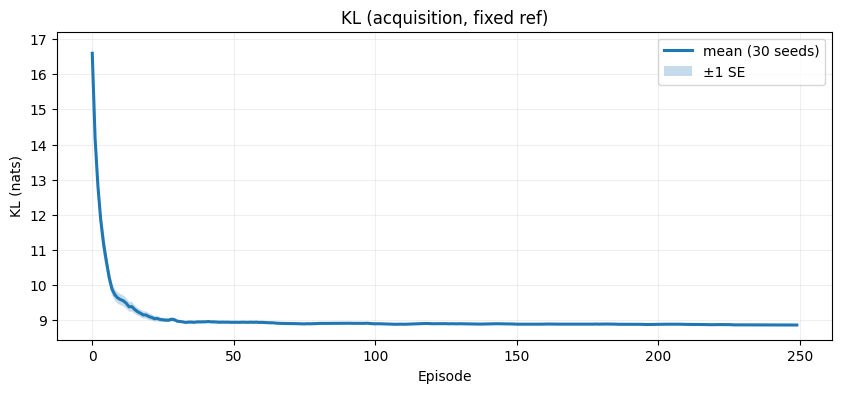

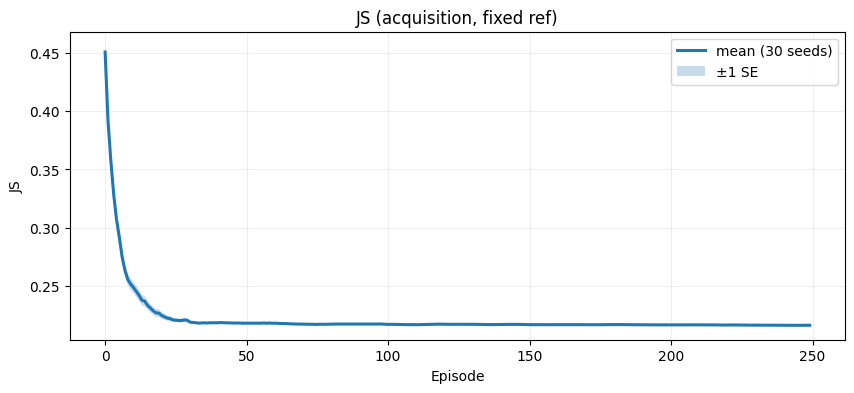

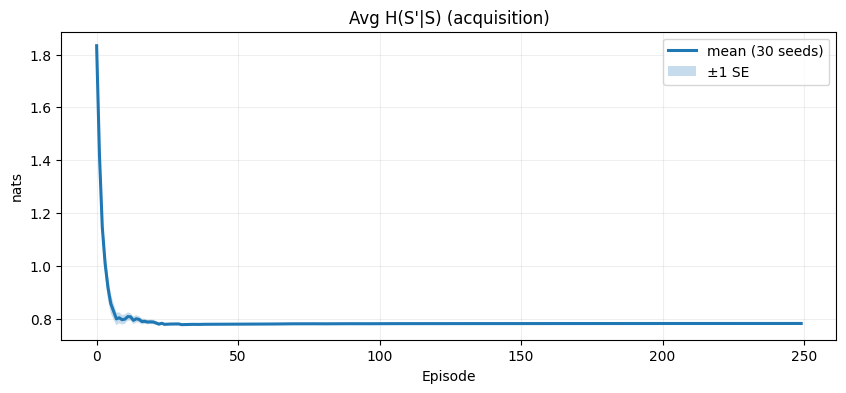

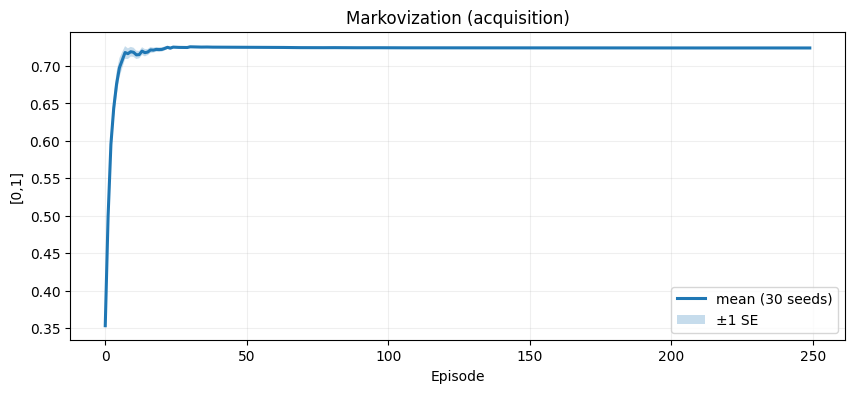

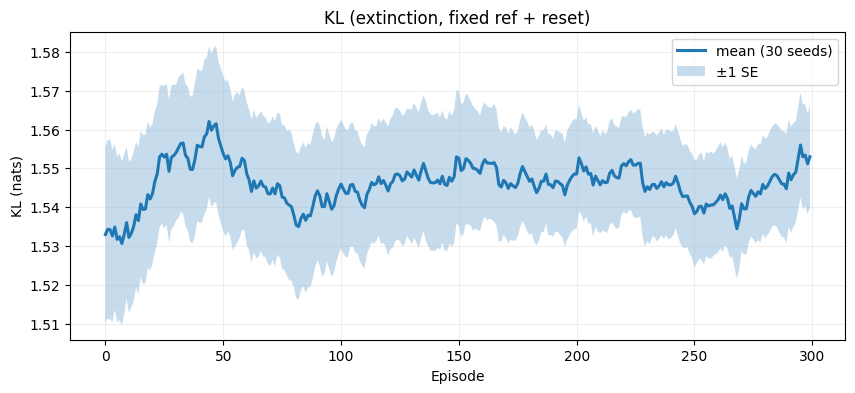

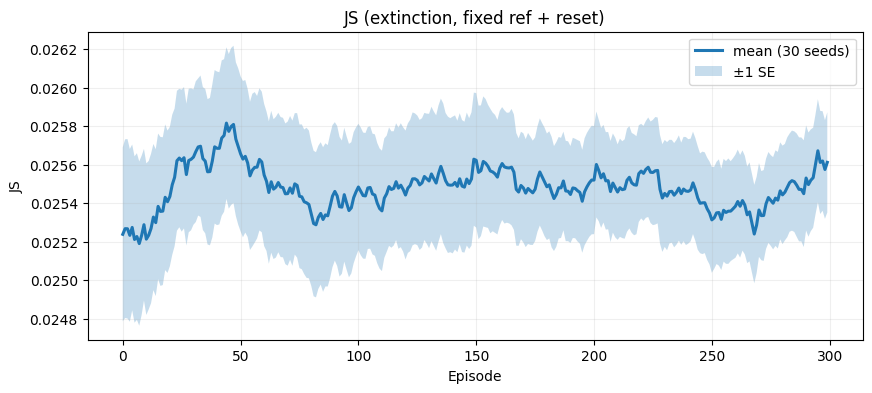

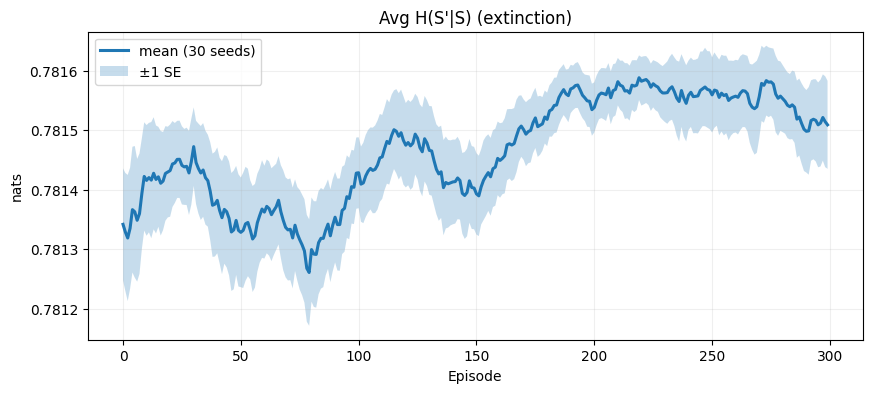

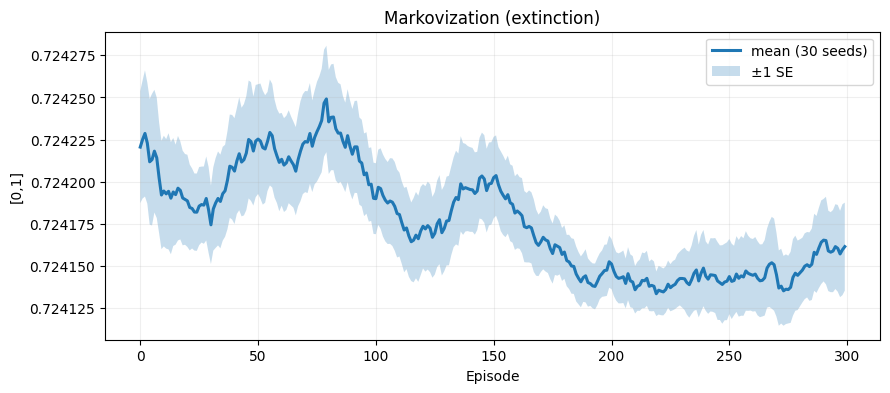

In [7]:

def plot_band(y_runs, title, ylabel):
    mean, se = mean_se(y_runs)
    x = np.arange(len(mean))
    plt.plot(x, mean, lw=2.2, label=f"mean ({len(y_runs)} seeds)")
    plt.fill_between(x, mean-se, mean+se, alpha=0.25, label="±1 SE")
    plt.title(title); plt.xlabel("Episode"); plt.ylabel(ylabel); plt.legend(); plt.grid(alpha=0.2)

plt.figure(figsize=(10,4)); plot_band(KL_acq_runs, "KL (acquisition, fixed ref)", "KL (nats)"); plt.show()
plt.figure(figsize=(10,4)); plot_band(JS_acq_runs, "JS (acquisition, fixed ref)", "JS"); plt.show()
plt.figure(figsize=(10,4)); plot_band(H_acq_runs,  "Avg H(S'|S) (acquisition)", "nats"); plt.show()
plt.figure(figsize=(10,4)); plot_band(MS_acq_runs, "Markovization (acquisition)", "[0,1]"); plt.show()

plt.figure(figsize=(10,4)); plot_band(KL_ext_runs, "KL (extinction, fixed ref + reset)", "KL (nats)"); plt.show()
plt.figure(figsize=(10,4)); plot_band(JS_ext_runs, "JS (extinction, fixed ref + reset)", "JS"); plt.show()
plt.figure(figsize=(10,4)); plot_band(H_ext_runs,  "Avg H(S'|S) (extinction)", "nats"); plt.show()
plt.figure(figsize=(10,4)); plot_band(MS_ext_runs, "Markovization (extinction)", "[0,1]"); plt.show()


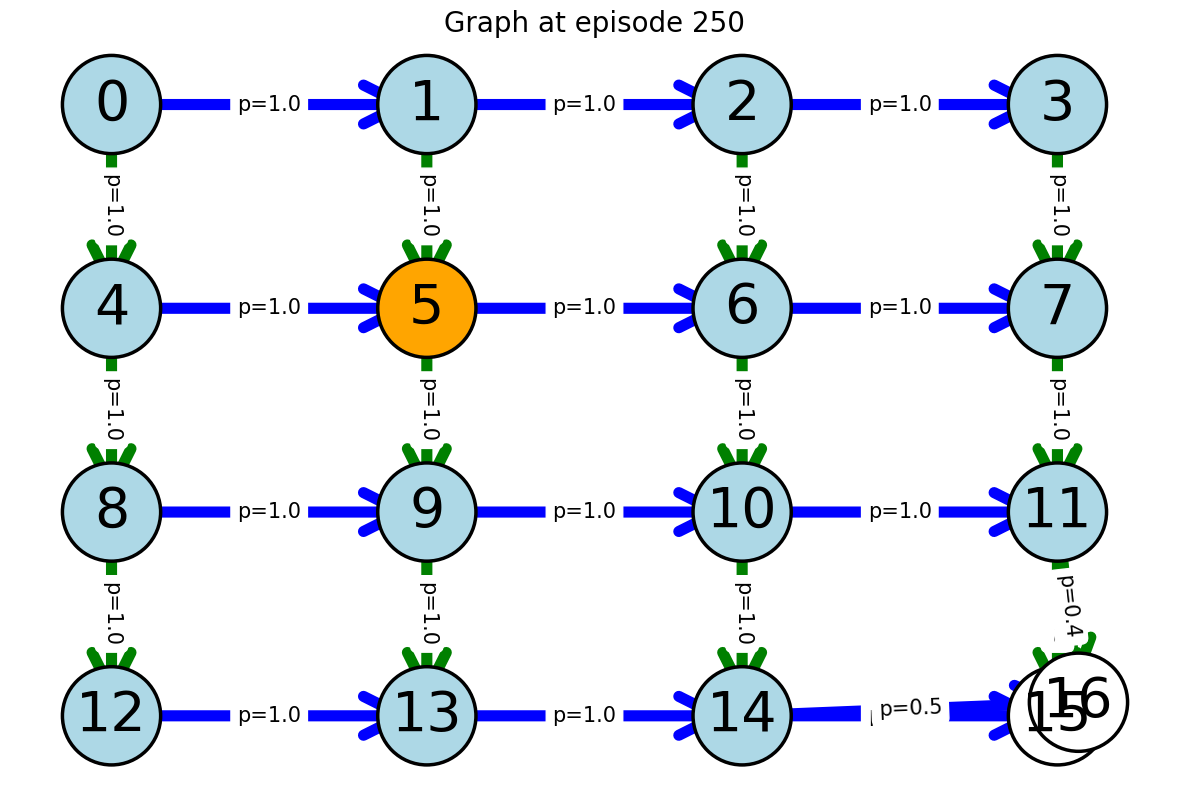

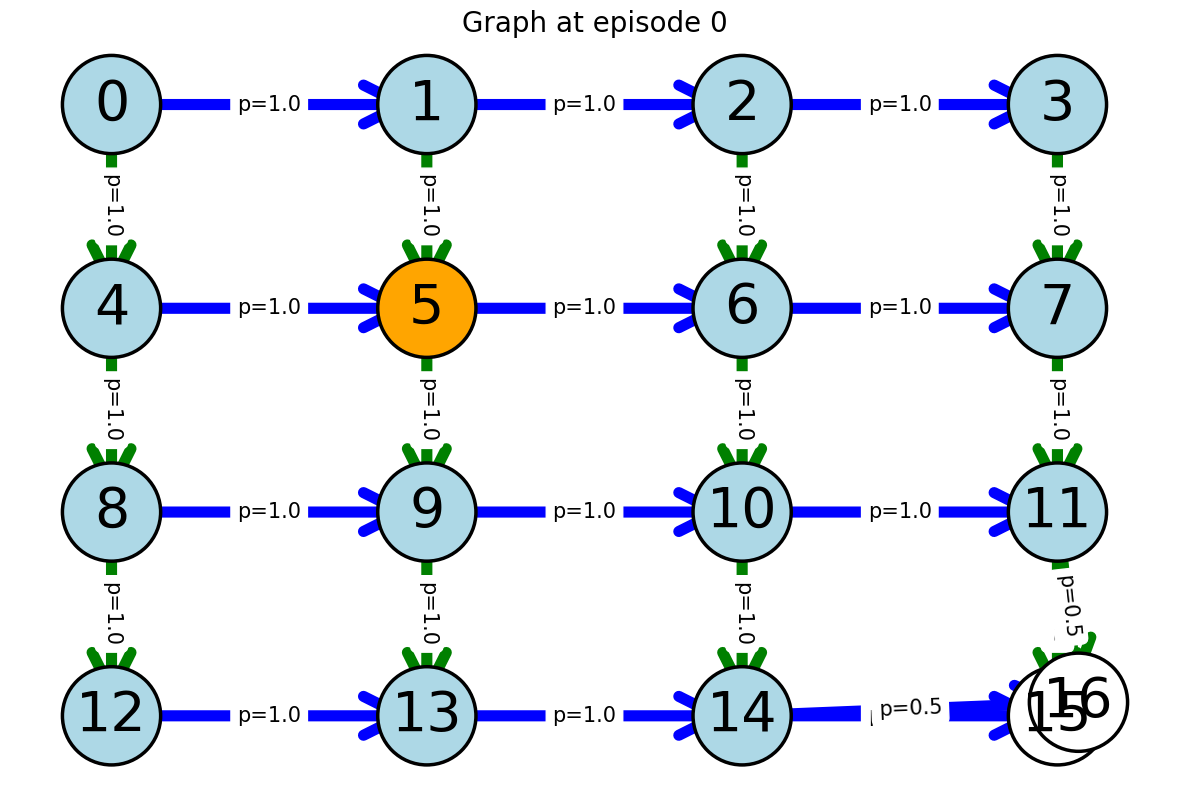

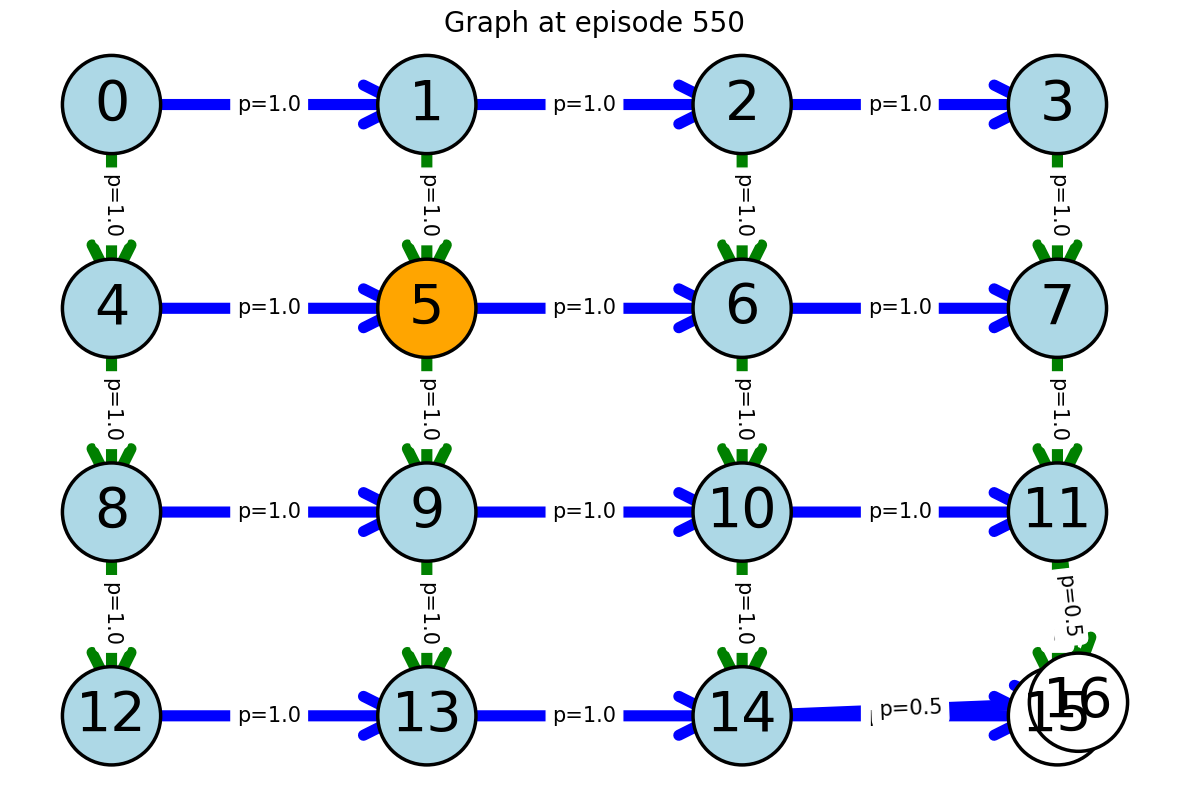

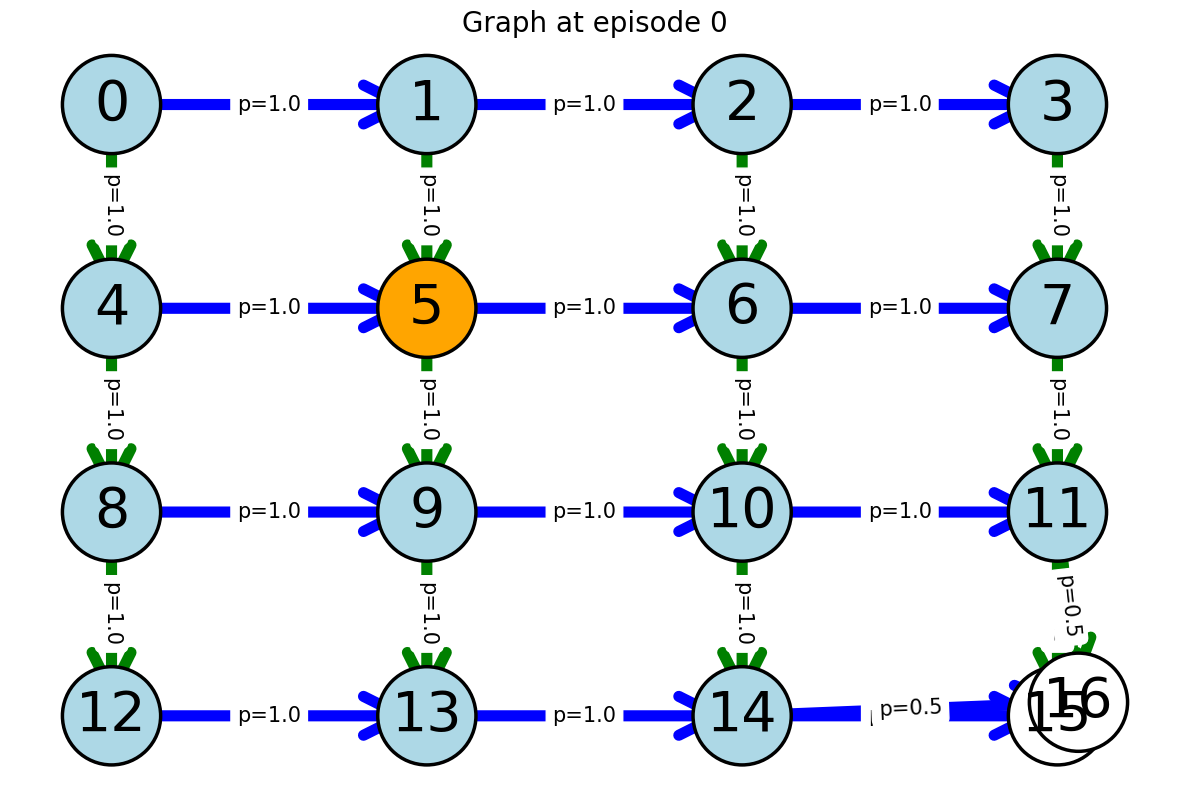

In [8]:
# === Final representation (one seed) with ground-truth comparators (uniform GT) ===
import numpy as np

from spatial_environments import GridEnvRightDownNoSelf, GridEnvRightDownNoCue
from util import generate_dataset, generate_dataset_post_augmentation
from coda_trial_by_trial_util import CoDAAgent, CoDAConfig
from coda_metrics import ref_empirical_from_rollouts

# ---------- small helpers for clean figures ----------
def make_terminals_absorbing_for_plot(T, terminals):
    T = T.copy()
    for t in terminals:
        if t < T.shape[0]:
            T[t, :, :] = 0.0
    return T

def sanitize_for_plot(env, T, eps=1e-12):
    """Hide orphan/inactive clones so they don't show as 'funky' dots near terminals."""
    if T is None or getattr(T, "ndim", 0) != 3: return
    S = T.shape[0]
    out_mass = T.sum(axis=(1,2))
    in_mass  = T.sum(axis=(0,1))
    active = (out_mass + in_mass) > eps
    for cl in list(getattr(env, "clone_dict", {}).keys()):
        if cl >= S or not active[cl]:
            env.clone_dict.pop(cl, None)
    env.reverse_clone_dict = {parent: cl for cl, parent in env.clone_dict.items()}

def _pad3(arr: np.ndarray, shape: tuple) -> np.ndarray:
    """Zero-pad a [S, A, S] tensor to `shape` without cropping."""
    assert arr.ndim == 3 and len(shape) == 3, "Expected 3D tensors"
    S, A_dim, S2 = arr.shape
    Sg, Ag, S2g  = shape
    if (S, A_dim, S2) == (Sg, Ag, S2g):
        return arr
    out = np.zeros((Sg, Ag, S2g), dtype=float)
    out[:min(S, Sg), :min(A_dim, Ag), :min(S2, S2g)] = arr[:min(S, Sg), :min(A_dim, Ag), :min(S2, S2g)]
    return out

# --- Option A: uniform policy for GT so the map shows lines everywhere ---
def random_uniform_policy(env, s, acts):
    return np.random.choice(acts)

def build_fixed_ref_acq_uniform(env, nroll=6000, max_steps=20):
    return ref_empirical_from_rollouts(env, random_uniform_policy, n_episodes=nroll, max_steps=max_steps)

def build_fixed_ref_ext_uniform(env2, nroll=6000, max_steps=20):
    return ref_empirical_from_rollouts(env2, random_uniform_policy, n_episodes=nroll, max_steps=max_steps)

# ---------- user knobs ----------
SEED      = 7
N_ACQ     = 250
N_EXT     = 300
MAX_STEPS = 20
CUE       = 5
THRESH_LEARNED = 0.30   # your usual threshold
THRESH_GT      = 0.05   # LOWER threshold for GT so low-probability edges are drawn

cfg = CoDAConfig(
    theta_split=0.9, theta_merge=0.5,
    n_threshold=8, min_presence_episodes=8, min_effective_exposure=25.0,
    confidence=0.95,
    count_decay=0.995, trace_decay=0.99, retro_decay=0.99
)

np.random.seed(SEED)

# ---------- Acquisition (learned) ----------
env = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
agent = CoDAAgent(env, cfg)

with_clones = False
for ep in range(1, N_ACQ+1):
    if with_clones:
        (states, actions) = generate_dataset_post_augmentation(env, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
    else:
        (states, actions) = generate_dataset(env, n_episodes=1, max_steps=MAX_STEPS)[0]
    agent.update_with_episode(states, actions)
    if agent.maybe_split():
        with_clones = True

T_acq_final = agent.get_T().copy()

# ---------- Acquisition (ground-truth; UNIFORM) ----------
env_acq_gt = GridEnvRightDownNoSelf(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
T_ref_acq  = build_fixed_ref_acq_uniform(env_acq_gt, nroll=6000, max_steps=MAX_STEPS)

# ---------- Switch to extinction and continue learning ----------
env2 = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
env2.clone_dict = dict(getattr(env, "clone_dict", {}))                # carry mapping for generator
env2.reverse_clone_dict = dict(getattr(env, "reverse_clone_dict", {}))
agent.env = env2

for ep in range(N_ACQ+1, N_ACQ+N_EXT+1):
    (states, actions) = generate_dataset_post_augmentation(env2, agent.get_T(), n_episodes=1, max_steps=MAX_STEPS)[0]
    agent.update_with_episode(states, actions)
    agent.maybe_merge()

T_ext_final = agent.get_T().copy()

# ---------- Extinction (ground-truth; UNIFORM) ----------
env_ext_gt = GridEnvRightDownNoCue(cue_states=[CUE], env_size=(4,4), rewarded_terminal=[15])
T_ref_ext  = build_fixed_ref_ext_uniform(env_ext_gt, nroll=6000, max_steps=MAX_STEPS)

# ---------- Make shapes compatible & pretty for figures ----------
shape_all  = tuple(max(x,y) for x,y in zip(T_acq_final.shape, T_ref_acq.shape))
T_acq_final = _pad3(T_acq_final, shape_all)
T_ref_acq   = _pad3(T_ref_acq,   shape_all)

shape_all2  = tuple(max(x,y) for x,y in zip(T_ext_final.shape, T_ref_ext.shape))
T_ext_final = _pad3(T_ext_final, shape_all2)
T_ref_ext   = _pad3(T_ref_ext,   shape_all2)

# Make terminals absorbing (figure only)
T_acq_vis     = make_terminals_absorbing_for_plot(T_acq_final, env.rewarded_terminals + env.unrewarded_terminals)
T_ref_acq_vis = make_terminals_absorbing_for_plot(T_ref_acq,   env_acq_gt.rewarded_terminals + env_acq_gt.unrewarded_terminals)
T_ext_vis     = make_terminals_absorbing_for_plot(T_ext_final, env2.rewarded_terminals + env2.unrewarded_terminals)
T_ref_ext_vis = make_terminals_absorbing_for_plot(T_ref_ext,   env_ext_gt.rewarded_terminals + env_ext_gt.unrewarded_terminals)

# Clean clone artifacts for the figure (learned only)
sanitize_for_plot(env,  T_acq_vis)
sanitize_for_plot(env2, T_ext_vis)

# ---------- Plot: learned vs ground-truth for the chosen seed ----------
# 1) Learned (final acquisition)
env.plot_graph(T_acq_vis, niter=N_ACQ, threshold=THRESH_LEARNED, save=False, savename=f"seed{SEED}_acq_learned.png")

# 2) Ground-truth (acquisition; uniform policy, lower threshold so lines show)
env_acq_gt.plot_graph(T_ref_acq_vis, niter=0, threshold=THRESH_GT, save=False, savename=f"seed{SEED}_acq_groundtruth.png")

# 3) Learned (final extinction)
env2.plot_graph(T_ext_vis, niter=N_ACQ+N_EXT, threshold=THRESH_LEARNED, save=False, savename=f"seed{SEED}_ext_learned.png")

# 4) Ground-truth (extinction; uniform policy, lower threshold so lines show)
env_ext_gt.plot_graph(T_ref_ext_vis, niter=0, threshold=THRESH_GT, save=False, savename=f"seed{SEED}_ext_groundtruth.png")